In [ ]:
#Install dependencies
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

In [ ]:
#Process the excel sheet
def process_excel_data(file_path):
    wb = load_workbook(file_path, read_only=True)
    all_rainfall = []
    all_S = []
    disaster_occurred = []

    for sheet_name in wb.sheetnames:
        if not sheet_name[0].isdigit():  # Skip sheets that don't start with a number
            continue

        df = pd.read_excel(file_path, sheet_name=sheet_name)

        rainfall = df['Rainfall'].values
        S = df['S=S1+S2+S3'].values

        # Remove NaN values
        valid_indices = ~(np.isnan(rainfall) | np.isnan(S))
        rainfall = rainfall[valid_indices]
        S = S[valid_indices]

        if len(rainfall) > 0:
            max_rainfall_index = np.argmax(rainfall)
            disaster = np.zeros(len(rainfall))
            disaster[max_rainfall_index] = 1

            all_rainfall.extend(rainfall)
            all_S.extend(S)
            disaster_occurred.extend(disaster)

    return np.array(all_rainfall), np.array(all_S), np.array(disaster_occurred)

# change into numpy arrays for easy data processing
file_path = 'SWI (1).xlsx'
rainfall_array, S_array, disaster_array = process_excel_data(file_path)

print(f"Total data points: {len(rainfall_array)}")
print(f"Number of disaster occurrences: {np.sum(disaster_array)}")

Total data points: 3168
Number of disaster occurrences: 22.0


In [ ]:
#Data Summary
X = np.column_stack((S_array, rainfall_array))
y = disaster_array

print("Data summary:")
print(f"Rainfall range: {X[:, 0].min()} to {X[:, 0].max()}")
print(f"Soil-water index range: {X[:, 1].min()} to {X[:, 1].max()}")
print(f"Number of disaster occurrences: {np.sum(y)}")


Data summary:
Rainfall range: 21.299847305197375 to 164.87571236685392
Soil-water index range: 0.0 to 39.7312850952148
Number of disaster occurrences: 22.0


In [ ]:
# define RBF network
class RBFNetwork(BaseEstimator, RegressorMixin):
    def __init__(self, gamma=1.0, lambda_min=0.1, lambda_max=1.0):
        self.gamma = gamma
        self.lambda_min = lambda_min
        self.lambda_max = lambda_max

    def fit(self, X, y):
        self.X_train_ = X
        self.scaler = StandardScaler().fit(X)
        X_scaled = self.scaler.transform(X)

        self.x_min, self.x_max = X_scaled[:, 0].min(), X_scaled[:, 0].max()
        self.y_min, self.y_max = X_scaled[:, 1].min(), X_scaled[:, 1].max()
        x_range = np.linspace(self.x_min, self.x_max, 20)
        y_range = np.linspace(self.y_min, self.y_max, 20)
        self.centers = np.array([(x, y) for x in x_range for y in y_range])

        self.K = np.exp(-self.gamma * np.sum((X_scaled[:, np.newaxis] - self.centers) ** 2, axis=2))

        counts = np.sum(self.K > 0.1, axis=0)
        lambdas = self.lambda_min + (self.lambda_max - self.lambda_min) / (1 + counts)
        L = np.diag(lambdas)

        # Use y directly instead of inverting it
        self.w = np.linalg.solve(self.K.T @ self.K + L, self.K.T @ y)

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        K = np.exp(-self.gamma * np.sum((X_scaled[:, np.newaxis] - self.centers) ** 2, axis=2))
        predictions = K @ self.w
        # Ensure predictions are between 0 and 1
        return np.clip(predictions, 0, 1)

In [ ]:
def revise_cl(cl_points):
    revised = cl_points.copy()
    for i in range(1, len(revised)):
        if revised[i, 1] < revised[i-1, 1]:
            revised[i, 1] = revised[i-1, 1]
        if revised[i, 0] < revised[i-1, 0]:
            revised[i, 0] = revised[i-1, 0]
    return revised

def calculate_performance(cl, X, y):
    above_cl = (X[:, 1] >= np.interp(X[:, 0], cl[:, 0], cl[:, 1]))
    true_positives = np.sum(above_cl & (y == 1))
    false_positives = np.sum(above_cl & (y == 0))
    disaster_capture_ratio = true_positives / np.sum(y == 1)
    false_alarm_frequency = false_positives / np.sum(y == 0)
    return disaster_capture_ratio, false_alarm_frequency


RBFN Predictions summary:
Training prediction range: 0.0 to 1.0
Grid prediction range: 0.0 to 1.0
No contour line generated for level 1.00
Critical line coordinates saved to 'critical_line.csv'
Optimal CL level: 0.05
Disaster capture ratio: 0.68
False alarm frequency: 0.01


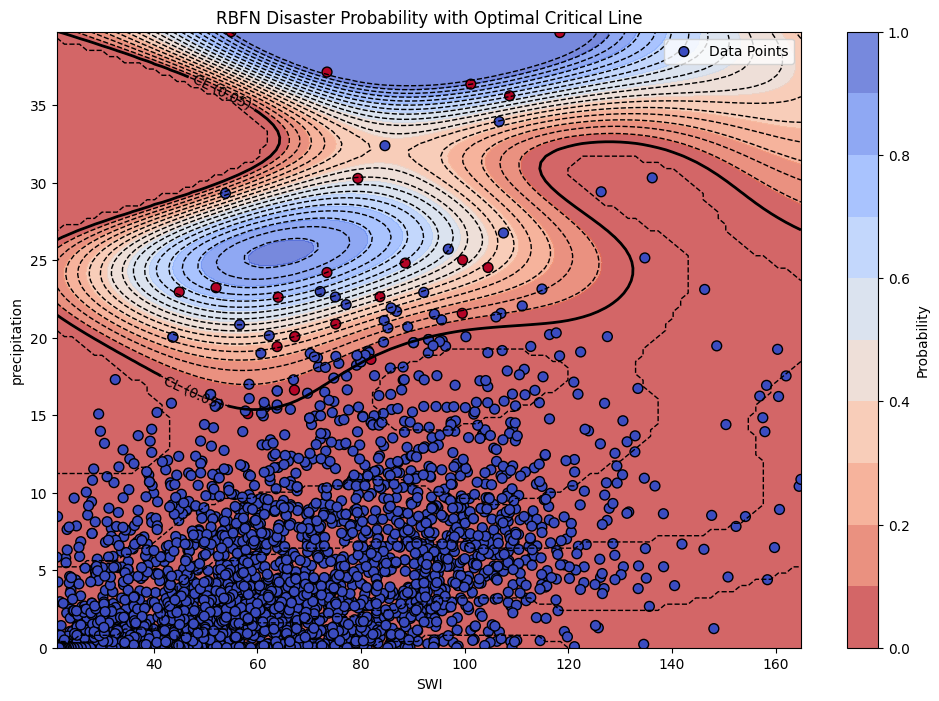

In [ ]:
# Train RBFN
rbfn = RBFNetwork(gamma=0.5, lambda_min=0.1, lambda_max=1.0)
rbfn.fit(X, y)
# After fitting the RBFN model
train_predictions = rbfn.predict(X)
print("\nRBFN Predictions summary:")
print(f"Training prediction range: {train_predictions.min()} to {train_predictions.max()}")

grid_x, grid_y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                             np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

predictions = rbfn.predict(grid_points).reshape(grid_x.shape)

# After generating predictions for the grid
print(f"Grid prediction range: {predictions.min()} to {predictions.max()}")

plt.figure(figsize=(12, 8))
contour = plt.contourf(grid_x, grid_y, predictions, levels=np.linspace(0, 1, 11), cmap='coolwarm_r', alpha=0.75)
plt.colorbar(contour, label='Probability')

scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm', s=50, label='Data Points')

# Generate and evaluate multiple CL candidates
cl_candidates = []
performance_metrics = []
for level in np.linspace(predictions.min(), predictions.max(), 20):
    cl = plt.contour(grid_x, grid_y, predictions, levels=[level], colors='black', linestyles='dashed', linewidths=1)
    if len(cl.allsegs) > 0 and len(cl.allsegs[0]) > 0:
        cl_points = cl.allsegs[0][0]
        revised_cl = revise_cl(cl_points)
        cl_candidates.append(revised_cl)

        disaster_capture_ratio, false_alarm_frequency = calculate_performance(revised_cl, X, y)
        performance_metrics.append((level, disaster_capture_ratio, false_alarm_frequency))
    else:
        print(f"No contour line generated for level {level:.2f}")

# Only proceed if we have valid candidates
if performance_metrics:
    # Select optimal CL based on performance metrics
    optimal_cl = max(performance_metrics, key=lambda x: x[1] - x[2])
    optimal_level = optimal_cl[0]

    # Plot the optimal CL
    optimal_cl_contour = plt.contour(grid_x, grid_y, predictions, levels=[optimal_level], colors='black', linestyles='solid', linewidths=2)
    plt.clabel(optimal_cl_contour, inline=True, fontsize=10, fmt=f'CL ({optimal_level:.2f})')

    # After plotting the optimal CL
    optimal_cl_coords = optimal_cl_contour.allsegs[0][0]
    np.savetxt('critical_line.csv', optimal_cl_coords, delimiter=',', header='SWI,precipitation')

    print("Critical line coordinates saved to 'critical_line.csv'")
    print(f"Optimal CL level: {optimal_level:.2f}")
    print(f"Disaster capture ratio: {optimal_cl[1]:.2f}")
    print(f"False alarm frequency: {optimal_cl[2]:.2f}")
else:
    print("No valid contour lines were generated. Please check your data and RBFN model.")
plt.xlabel('SWI')
plt.ylabel('precipitation')
plt.title('RBFN Disaster Probability with Optimal Critical Line')
plt.legend()
plt.show()
# print(f"Optimal CL level: {optimal_level:.2f}")
# print(f"Disaster capture ratio: {optimal_cl[1]:.2f}")
# print(f"False alarm frequency: {optimal_cl[2]:.2f}")